# Biographical Timelines - Marie & Pierre Curie ☢

---

Our goal is to selectively extract sentences from two seperate reference texts, whereby the sentence must contain a date (in any format). We will implement a data mining pipeline, which takes a filename as an input and produces a table of every date-sentence pair found within the text file. 

Importantly, we will build the pipeline specifically to handle Pierre's text, and explicitly ignore Marie's until completion. Essentially we are mimicking a training and testing set, to establish whether our pipeline holds up on unseen data.

Once we have the pipeline completed, we will manually evaluate its performance by calculating a confusion matrix for each text document, paying particular attention to **precision** and **recall**. The difference in precision between our performance on the training and testing documents will inform us about the generalizability of our pipeline.


Finally, we will cross-reference the two sources by date, attempting to establish a "joint timeline" of events which included both of our subjects.

Sounds fun, let's gooooo

## File Reading 📑

---

Load the .txt file into memory as a string.

In [46]:
#Import Dependencies
import pandas as pd
import numpy as np
from functools import reduce
import calendar
import re
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import nltk
from nltk import tokenize
from datetime import timedelta

#Fancy timeline graphs!
%pip install plotly --upgrade
import plotly.express as px
import plotly.graph_objects as go
#Setup
nltk.download('punkt')
root_path = "/content/"

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.10.0)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
def read_file(fname):
  with open(fname, "r") as f:
    return f.read()

pierre = read_file(root_path+"pierre.txt")
print(pierre)

Pierre Curie
From Wikipedia, the free encyclopedia

Pierre Curie (/ˈkjʊəri/, KEWR-ee;[1] French: [pjɛʁ kyʁi]; 15 May 1859 – 19 April 1906) was a French physicist, a pioneer in crystallography, magnetism, piezoelectricity, and radioactivity. In 1903, he received the Nobel Prize in Physics with his wife, Marie Skłodowska-Curie, and Henri Becquerel, "in recognition of the extraordinary services they have rendered by their joint researches on the radiation phenomena discovered by Professor Henri Becquerel".[2]

Early life

Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie (28 August 1827 – 25 February 1910), a doctor of French Huguenot Protestant origin from Alsace, and Sophie-Claire Depouilly Curie (15 January 1832 – 27 September 1897). He was educated by his father and in his early teens showed a strong aptitude for mathematics and geometry. When he was 16, he earned his math degree.[clarification needed] By the age of 18, he earned a higher degree, but did not proce

## Pierre - Overview 👨‍🦳

---



Looking at Pierre's text, we notice a few different datetime formats being used:



1.   `DD MONTH YYYY`
2.   `MONTH YYYY`
3.   `YYYY`


Luckily, there are no anomalous dates which fall outside of these three cases. Even better, each case is actually a subset of the previous, allowing for heirarchical filtering and cleaner regex.

However, I've spotten one issue that I imagine will be difficult to handle - 

> *(3.7 × 1010 decays per second or 37 gigabecquerels)*

Four-digit numbers are likely to be picked up as `YYYY` formatted year strings. In Pierre's specific example, perhaps we could introduce a minimum & maximum bound for the year number. Maybe even based on a range around the mean or mode of all the years mentioned in the text?

However, there is no easy way to distinguish between dates and numbers, especially if they are of similar (or even identical) magnitude. This could be a fun NLP task! We could train a classifier to distinguish between years and values based on the surrounding context of the article. Sadly it seems a little out-of-scope for this assignment, so we'll have to make do with some inaccuracies.


In [48]:
months = [calendar.month_name[i] for i in range(1, 13)]

#Matches 4 digits in a row
yyyy_pattern = "[0-9]{4}"
pierre_years = re.findall(yyyy_pattern, pierre)

#Match any month, a space, then any 4 digits.
month_yyyy_pattern = f"(?:{'|'.join(months)})\s*{yyyy_pattern}"
pierre_monthyears = re.findall(month_yyyy_pattern, pierre, flags=re.IGNORECASE)

#Match 1 or 2 digits, then any month, then 4 digits
dd_month_yyyy_pattern = "[0-9]{1,2}\s*" + month_yyyy_pattern
pierre_daymonthyears = re.findall(dd_month_yyyy_pattern, pierre, flags=re.IGNORECASE)

print(f"Pattern {yyyy_pattern} found the following matches: \n", pierre_years)
print(f"\nPattern {month_yyyy_pattern} found the following matches: \n", pierre_monthyears)
print(f"\nPattern {dd_month_yyyy_pattern} found the following matches: \n", pierre_daymonthyears)

#Now if we apply these patterns together with ordered OR operations,
#We can heirarchically select the match with the most information
heirarchical_pattern = f"({dd_month_yyyy_pattern}|{month_yyyy_pattern}|{yyyy_pattern})"
pierre_dates = re.findall(heirarchical_pattern, pierre, flags=re.IGNORECASE)

print(f"\nPattern {heirarchical_pattern} found the following matches: \n", pierre_dates)

#Quick sense-check; 
#our fancy pattern should return exactly as many matches as the year pattern alone.
assert len(pierre_years) == len(pierre_dates)
print("Final match count: ", len(pierre_dates))

Pattern [0-9]{4} found the following matches: 
 ['1859', '1906', '1903', '1859', '1827', '1910', '1832', '1897', '1880', '1856', '1941', '1895', '1898', '2015', '1010', '1910', '1905', '1965', '1906', '1934', '1890', '1995']

Pattern (?:January|February|March|April|May|June|July|August|September|October|November|December)\s*[0-9]{4} found the following matches: 
 ['May 1859', 'April 1906', 'May 1859', 'August 1827', 'February 1910', 'January 1832', 'September 1897', 'July 1895', 'April 1906', 'April 1995']

Pattern [0-9]{1,2}\s*(?:January|February|March|April|May|June|July|August|September|October|November|December)\s*[0-9]{4} found the following matches: 
 ['15 May 1859', '19 April 1906', '15 May 1859', '28 August 1827', '25 February 1910', '15 January 1832', '27 September 1897', '26 July 1895', '19 April 1906']

Pattern ([0-9]{1,2}\s*(?:January|February|March|April|May|June|July|August|September|October|November|December)\s*[0-9]{4}|(?:January|February|March|April|May|June|July|Augus

## Sentence Tokenization 🔖

---


Excellent! With our final Regex pattern, we can heirarchically match the date string containing the largest amount of information possible in each case.

Alongside the date, we'd like the context of where it came from. Since we have a multi-line file, the simplest way to do this would seem to be matching the whole line of text. We can do a better though! Let's try using the NLTK library to split by sentence.

In [49]:
#Generate flattened list of Sentences,
#Excluding Wikipedia citation [#]'s & empty lines
def filestring_to_sentences(in_file):
  return reduce(lambda z, y: z + y, \
          [tokenize.sent_tokenize( \
              re.sub("(\[[0-9]{1,3}\])|(:[0-9]{1,3})",'', line)) \
                for line in in_file.splitlines() \
                  if line != ''])   

sentences = filestring_to_sentences(pierre)
sentences

['Pierre Curie',
 'From Wikipedia, the free encyclopedia',
 'Pierre Curie (/ˈkjʊəri/, KEWR-ee; French: [pjɛʁ kyʁi]; 15 May 1859 – 19 April 1906) was a French physicist, a pioneer in crystallography, magnetism, piezoelectricity, and radioactivity.',
 'In 1903, he received the Nobel Prize in Physics with his wife, Marie Skłodowska-Curie, and Henri Becquerel, "in recognition of the extraordinary services they have rendered by their joint researches on the radiation phenomena discovered by Professor Henri Becquerel".',
 'Early life',
 'Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie (28 August 1827 – 25 February 1910), a doctor of French Huguenot Protestant origin from Alsace, and Sophie-Claire Depouilly Curie (15 January 1832 – 27 September 1897).',
 'He was educated by his father and in his early teens showed a strong aptitude for mathematics and geometry.',
 'When he was 16, he earned his math degree.',
 '[clarification needed] By the age of 18, he earned a higher

## Matching Sentences & Dates 📅

---

Great, we have sentences! Let's re-associate them with their respective dates.


> **NOTE: *Sentences containing multiple $N$ dates will be DUPLICATED $N$ times.***

In my opinion, this is superior to a lazy-evaluation of first-match-only.

In [50]:
#Find dates within a sentence.
#Note: Generates duplicate sentence rows for every date within that sentence.
def sentence_date_match(sentences):
  for sentence in sentences:
    match = re.findall(heirarchical_pattern, sentence, flags=re.IGNORECASE)
    if not match: continue
    for date in match:
      yield {"Date": date, "Sentence": sentence}

date_sentence_df = pd.DataFrame(sentence_date_match(sentences))
date_sentence_df

,Date,Sentence
0,15 May 1859,"Pierre Curie (/ˈkjʊəri/, KEWR-ee; French: [pjɛ..."
1,19 April 1906,"Pierre Curie (/ˈkjʊəri/, KEWR-ee; French: [pjɛ..."
2,1903,"In 1903, he received the Nobel Prize in Physic..."
3,15 May 1859,"Born in Paris on 15 May 1859, Pierre Curie was..."
4,28 August 1827,"Born in Paris on 15 May 1859, Pierre Curie was..."
5,25 February 1910,"Born in Paris on 15 May 1859, Pierre Curie was..."
6,15 January 1832,"Born in Paris on 15 May 1859, Pierre Curie was..."
7,27 September 1897,"Born in Paris on 15 May 1859, Pierre Curie was..."
8,1880,"In 1880, Pierre and his older brother Jacques ..."
9,1856,"In 1880, Pierre and his older brother Jacques ..."


## ISO Date Formatting 📏


---


For every date match we find, convert into ISO-8601 format (YYYY-MM-DD), then order them chronologically.

In [51]:
#Again attempt to parse each date format in most-information-order
def try_parse_datetime(datestr):
  formats = ["%d %B %Y", "%B %Y", "%Y"]
  for f in formats:
    try:
        return pd.to_datetime(datetime.strptime(datestr, f))
    except:
      continue

date_sentence_df["ISO"] = pd.to_datetime(date_sentence_df["Date"].apply(try_parse_datetime))
date_sentence_df.set_index("ISO").sort_index()

,Date,Sentence
ISO,,
1827-08-28,28 August 1827,"Born in Paris on 15 May 1859, Pierre Curie was..."
1832-01-15,15 January 1832,"Born in Paris on 15 May 1859, Pierre Curie was..."
1856-01-01,1856,"In 1880, Pierre and his older brother Jacques ..."
1859-05-15,15 May 1859,"Pierre Curie (/ˈkjʊəri/, KEWR-ee; French: [pjɛ..."
1859-05-15,15 May 1859,"Born in Paris on 15 May 1859, Pierre Curie was..."
1880-01-01,1880,"In 1880, Pierre and his older brother Jacques ..."
1890-01-01,1890,"Even now, all their papers from the 1890s, eve..."
1895-07-26,26 July 1895,"She refused his initial proposal, but finally ..."
1897-09-27,27 September 1897,"Born in Paris on 15 May 1859, Pierre Curie was..."


## Pipeline - Tie it all Together 🔩


---

Here we package the entire pipeline into a single endpoint, enabling easy re-use for data extraction on new text files.



In [52]:
"""
Extracts sentences containing dates from a text file,
producing a table of sentences indexed by ISO date,
sorted chronologically.

  
  str fname: 
      Path to the subject text file.

  returns:
    A Pandas DataFrame containing: 
      Date - The raw timestamp string matched from the text file.
      Sentence - The sentence that date was found inside of.
      ISO (index) - Parsed from the Date column into ISO-8601 format.
"""
def file_to_dates_with_sentences(fname):
  #Read the raw file
  in_file = read_file(fname)
  #Convert lines into sentences
  sentences = filestring_to_sentences(in_file)
  #Generate dataframe of sentences which contain dates
  df = pd.DataFrame(sentence_date_match(sentences))
  #Format dates into ISO
  df["ISO"] = pd.to_datetime(df["Date"].apply(try_parse_datetime))
  #Remove any failed NotATime values
  df.dropna(inplace=True)
  #Sort chronologically
  return df.set_index("ISO").sort_index()

file_to_dates_with_sentences(root_path+"pierre.txt")

,Date,Sentence
ISO,,
1827-08-28,28 August 1827,"Born in Paris on 15 May 1859, Pierre Curie was..."
1832-01-15,15 January 1832,"Born in Paris on 15 May 1859, Pierre Curie was..."
1856-01-01,1856,"In 1880, Pierre and his older brother Jacques ..."
1859-05-15,15 May 1859,"Pierre Curie (/ˈkjʊəri/, KEWR-ee; French: [pjɛ..."
1859-05-15,15 May 1859,"Born in Paris on 15 May 1859, Pierre Curie was..."
1880-01-01,1880,"In 1880, Pierre and his older brother Jacques ..."
1890-01-01,1890,"Even now, all their papers from the 1890s, eve..."
1895-07-26,26 July 1895,"She refused his initial proposal, but finally ..."
1897-09-27,27 September 1897,"Born in Paris on 15 May 1859, Pierre Curie was..."


## Marie Curie 👩‍🦳

---



Run our pipeline on the unseen text file, and have a quick peek at how well we're doing.

In [53]:
file_to_dates_with_sentences(root_path+"marie.txt")

,Date,Sentence
ISO,,
1863-01-01,1863,"On both the paternal and maternal sides, the f..."
1867-11-07,7 November 1867,Marie Skłodowska Curie (/ˈkjʊəri/ KEWR-ee; Fre...
1890-01-01,1890,"At the beginning of 1890, Bronisława—who a few..."
1891-01-01,1891,"In late 1891, she left Poland for France."
1895-07-26,26 July 1895,"On 26 July 1895, Pierre and Marie were married..."
1897-01-01,1897,"In 1897, her daughter Irène was born."
1898-01-01,1898,By mid-1898 he was so invested in it that he d...
1898-01-01,1898,"Between 1898 and 1902, the Curies published, j..."
1898-07-01,July 1898,"In July 1898, Curie and her husband published ..."


# Evaluating The Pipeline 🧪

---
Woo, that looks promising! Our pipeline found a lot of matches on the unseen file, and the ones it did find look logically consistent with what we're expecting.


Let's do better than just eyeballing it. We will manually read through each file, generate the labels we expect, and compare them to the automated pipeline's results. 


> *Pseudocode for our manual labelling process is as follows:*


```
  for each Sentence in TextFile:

    if Sentence contains a Date:
      for each Date in Sentence:
        Save (Date, Sentence) as True Positive

    else: #Sentence does not contain any Dates
      Save (NULL, Sentence) as True Negative
```

To allow for direct programatic comparison of our manual results and the automated ones, we shall again split the documents into sentences using `filestring_to_sentences()` function. *Promise I'm not cheating!* if we precisely define a sentence as:

> `Sentence = TEXT + [ . | ! | ? | NewLine] `

then both manual process and NLTK's Tokenize function produce the same results (except in two specific cases, see code comments below).


> **NOTE:** Remember, for sentences containing multiple dates, we decide to duplicate the sentences per found date.

## Manual Labelling ⛏

---

What a fun and exciting task 😉

In [54]:
#Hoo boy, here we go...
pierre_manual_results = [
  {"Dates": [], "Sentence": "Pierre Curie"},
  {"Dates": [], "Sentence": "From Wikipedia, the free encyclopedia"},
  {"Dates": ["1859-05-15", "1906-04-19"], "Sentence": "Pierre Curie (/ˈkjʊəri/, KEWR-ee; French: [pjɛʁ kyʁi]; 15 May 1859 – 19 April 1906) was a French physicist, a pioneer in crystallography, magnetism, piezoelectricity, and radioactivity."},
  {"Dates": ["1903"], "Sentence": "In 1903, he received the Nobel Prize in Physics with his wife, Marie Skłodowska-Curie, and Henri Becquerel, \"in recognition of the extraordinary services they have rendered by their joint researches on the radiation phenomena discovered by Professor Henri Becquerel\"."},
  {"Dates": [], "Sentence": "Early Life"},
  {"Dates": ["1859-05-15","1827-08-28","1910-02-25","1832-01-15","1897-09-27"], "Sentence": "Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie (28 August 1827 – 25 February 1910), a doctor of French Huguenot Protestant origin from Alsace, and Sophie-Claire Depouilly Curie (15 January 1832 – 27 September 1897)."},
  {"Dates": [], "Sentence": "He was educated by his father and in his early teens showed a strong aptitude for mathematics and geometry."},
  {"Dates": [], "Sentence": "When he was 16, he earned his math degree."},
  {"Dates": [], "Sentence": "[clarification needed] By the age of 18, he earned a higher degree, but did not proceed immediately to a doctorate due to lack of money."},
  {"Dates": [], "Sentence": "Instead, he worked as a laboratory instructor."},
  {"Dates": [], "Sentence": "When Pierre Curie was preparing for his bachelor of science degree, he worked in the laboratory of Jean-Gustave Bourbouze in the Faculty of Science."},
  {"Dates": ["1880","1856","1941"], "Sentence": "In 1880, Pierre and his older brother Jacques (1856–1941) demonstrated that an electric potential was generated when crystals were compressed, i.e."},
  {"Dates": [], "Sentence": "piezoelectricity."}, #Weird one, the use of i.e. is an edge case for our sentence definition
  {"Dates": [], "Sentence": "To aid this work they invented the piezoelectric quartz electrometer."},
  {"Dates": [], "Sentence": "The following year they demonstrated the reverse effect: that crystals could be made to deform when subject to an electric field."},
  {"Dates": [], "Sentence": "Almost all digital electronic circuits now rely on this in the form of crystal oscillators."},
  {"Dates": [], "Sentence": "In subsequent work on magnetism Pierre Curie defined the Curie scale."},
  {"Dates": [], "Sentence": "This work also involved delicate equipment - balances, electrometers, etc."},
  {"Dates": [], "Sentence": "Pierre Curie was introduced to Maria Skłodowska by their friend, physicist Józef Wierusz-Kowalski."},
  {"Dates": [], "Sentence": "Curie took her into his laboratory as his student."},
  {"Dates": [], "Sentence": "His admiration for her grew when he realized that she would not inhibit his research."},
  {"Dates": [], "Sentence": "He began to regard Skłodowska as his muse."},
  {"Dates": ["1895-07-26"], "Sentence": "She refused his initial proposal, but finally agreed to marry him on 26 July 1895."},
  {"Dates": [], "Sentence": "It would be a beautiful thing, a thing I dare not hope if we could spend our life near each other, hypnotized by our dreams: your patriotic dream, our humanitarian dream, and our scientific dream."},
  {"Dates": [], "Sentence": "[Pierre Curie to Maria Skłodowska]:117"},#Comes after a period, it's a sentence.
  {"Dates": [], "Sentence": "The Curies had a happy, affectionate marriage, and they were known for their devotion to each other."},
  {"Dates": [], "Sentence": "Research"},
  {"Dates": [], "Sentence": "Before his famous doctoral studies on magnetism, he designed and perfected an extremely sensitive torsion balance for measuring magnetic coefficients."},
  {"Dates": [], "Sentence": "Variations on this equipment were commonly used by future workers in that area."},
  {"Dates": [], "Sentence": "Pierre Curie studied ferromagnetism, paramagnetism, and diamagnetism for his doctoral thesis, and discovered the effect of temperature on paramagnetism which is now known as Curie\'s law."},
  {"Dates": [], "Sentence": "The material constant in Curie\'s law is known as the Curie constant."},
  {"Dates": [], "Sentence": "He also discovered that ferromagnetic substances exhibited a critical temperature transition, above which the substances lost their ferromagnetic behavior."},
  {"Dates": [], "Sentence": "This is now known as the Curie temperature."},
  {"Dates": [], "Sentence": "The Curie temperature is used to study plate tectonics, treat hypothermia, measure caffeine, and to understand extraterrestrial magnetic fields."},
  {"Dates": [], "Sentence": "Pierre Curie formulated what is now known as the Curie Dissymmetry Principle: a physical effect cannot have a dissymmetry absent from its efficient cause."},
  {"Dates": [], "Sentence": "For example, a random mixture of sand in zero gravity has no dissymmetry (it is isotropic)."},
  {"Dates": [], "Sentence": "Introduce a gravitational field, and there is a dissymmetry because of the direction of the field."},
  {"Dates": [], "Sentence": "Then the sand grains can \'self-sort\' with the density increasing with depth."},
  {"Dates": [], "Sentence": "But this new arrangement, with the directional arrangement of sand grains, actually reflects the dissymmetry of the gravitational field that causes the separation."},
  {"Dates": [], "Sentence": "Curie worked with his wife in isolating polonium and radium."},
  {"Dates": [], "Sentence": "They were the first to use the term \"radioactivity\", and were pioneers in its study."},
  {"Dates": [], "Sentence": "Their work, including Marie Curie\'s celebrated doctoral work, made use of a sensitive piezoelectric electrometer constructed by Pierre and his brother Jacques Curie."},
  {"Dates": ["1898-01-01", "2015-01-01"], "Sentence": "Pierre Curie\'s 1898 publication with his wife and M. G. Bémont for their discovery of radium and polonium was honored by a Citation for Chemical Breakthrough Award from the Division of History of Chemistry of the American Chemical Society presented to the ESPCI ParisTech (officially the École supérieure de physique et de Chimie industrielles de la Ville de Paris) in 2015."},
  {"Dates": [], "Sentence": "Curie and one of his students, Albert Laborde, made the first discovery of nuclear energy, by identifying the continuous emission of heat from radium particles."},
  {"Dates": [], "Sentence": "Curie also investigated the radiation emissions of radioactive substances, and through the use of magnetic fields was able to show that some of the emissions were positively charged, some were negative and some were neutral."},
  {"Dates": [], "Sentence": "These correspond to alpha, beta and gamma radiation."},
  {"Dates": ["1910-01-01"], "Sentence": "The curie is a unit of radioactivity (3.7 × 1010 decays per second or 37 gigabecquerels) originally named in honor of Curie by the Radiology Congress in 1910, after his death."},
  {"Dates": [], "Sentence": "Subsequently, there has been some controversy over whether the naming was in honor of Pierre, Marie, or both."},
  {"Dates": [], "Sentence": "Spiritualism"},
  {"Dates": [], "Sentence": "In the late nineteenth century, Pierre Curie was investigating the mysteries of ordinary magnetism when he became aware of the spiritualist experiments of other European scientists, such as Charles Richet and Camille Flammarion."},
  {"Dates": [], "Sentence": "Pierre Curie initially thought the systematic investigation into the paranormal could help with some unanswered questions about magnetism."},
  {"Dates": [], "Sentence": ":65 He wrote to his fiancée Marie: \"I must admit that those spiritual phenomena intensely interest me."},
  {"Dates": [], "Sentence": " I think they are questions that deal with physics."},
  {"Dates": [], "Sentence": "\":66 Pierre Curie\'s notebooks from this period show he read many books on spiritualism."},
  #Aha, a genuine failure for our pipeline! 1905-06 means 1905 AND 1906, 
  #but we're only matching the complete YYYY format.
  {"Dates": ["1905-01-01", "1906-01-01"], "Sentence": ":68 He did not attend séances such as those of Eusapia Palladino in Paris in 1905–06:238 as a mere spectator, and his goal certainly was not to communicate with spirits."},
  {"Dates": [], "Sentence": "He saw the séances as scientific experiments, tried to monitor different parameters, and took detailed notes of every observation."},
  {"Dates": [], "Sentence": ":247 Despite studying spiritualism, Curie was an atheist."},
  {"Dates": [], "Sentence": "Family"},
  {"Dates": [], "Sentence": "Pierre and Marie Curie\'s daughter, Irène, and their son-in-law, Frédéric Joliot-Curie, were also physicists involved in the study of radioactivity, and each received Nobel prizes for their work as well."},
  {"Dates": [], "Sentence": "The Curies' other daughter, Ève, wrote a noted biography of her mother."},
  {"Dates": [], "Sentence": "She was the only member of the Curie family to not become a physicist."},
  {"Dates": ["1965-01-01"], "Sentence": "Ève married Henry Richardson Labouisse, Jr., who received a Nobel Peace Prize on behalf of Unicef in 1965."},
  {"Dates": [], "Sentence": "Pierre and Marie Curie\'s granddaughter, Hélène Langevin-Joliot, is a professor of nuclear physics at the University of Paris, and their grandson, Pierre Joliot, who was named after Pierre Curie, is a noted biochemist."},
  {"Dates": [], "Sentence": "Death"},
  {"Dates": ["1906-04-19"], "Sentence": "Pierre Curie died in a street accident in Paris on 19 April 1906."},
  {"Dates": [], "Sentence": "Crossing the busy Rue Dauphine in the rain at the Quai de Conti, he slipped and fell under a heavy horse-drawn cart."},
  {"Dates": [], "Sentence": "He died instantly when one of the wheels ran over his head, fracturing his skull."},
  {"Dates": [], "Sentence": "Statements made by his father and lab assistant imply that Curie\'s characteristic absent-minded preoccupation with his thoughts contributed to his death."},
  {"Dates": [], "Sentence": "Both the Curies experienced radium burns, both accidentally and voluntarily, and were exposed to extensive doses of radiation while conducting their research."},
  {"Dates": ["1934-01-01"], "Sentence": "They experienced radiation sickness and Marie Curie died of aplastic anemia in 1934."},
  #Hmmm, 1890's? Could potentially make a case for including every year in that decade...
  {"Dates": ["1890-01-01"], "Sentence": "Even now, all their papers from the 1890s, even her cookbooks, are too dangerous to touch."},
  {"Dates": [], "Sentence": "Their laboratory books are kept in special lead boxes and people who want to see them have to wear protective clothing."},
  {"Dates": [], "Sentence": "Had Pierre Curie not been killed as he was, it is likely that he would have eventually died of the effects of radiation, as did his wife, their daughter Irène, and her husband Frédéric Joliot."},
  {"Dates": ["1995-04-01"], "Sentence": "In April 1995, Pierre and Marie Curie were moved from their original resting place, a family cemetery, and enshrined in the crypt of the Panthéon in Paris."},
  {"Dates": [], "Sentence": "Text extractions taken from Wikipedia, https://en.wikipedia.org/wiki/Pierre_Curie, and altered by Teaching Team."},  
]

pierre_automatic_results = file_to_dates_with_sentences(root_path+"pierre.txt")

In [55]:
#Omg that was so fun let's do it again
marie_manual_results = [
  {"Dates": [], "Sentence": "Marie Curie"},
  {"Dates": [], "Sentence": "From Wikipedia, the free encyclopedia"},
  {"Dates": ["1867-11-07", "1934-07-04"], "Sentence": "Marie Skłodowska Curie (/ˈkjʊəri/ KEWR-ee; French: [kyʁi]; Polish: [kʲiˈri]), born Maria Salomea Skłodowska (Polish: [ˈmarja salɔˈmɛa skwɔˈdɔfska]; 7 November 1867 – 4 July 1934), was a Polish and naturalized-French physicist and chemist who conducted pioneering research on radioactivity."},
  {"Dates": [], "Sentence": "Early years"},
  #Same issue as Pierre, date *ranges* (YYYY-YY) aren't captured properly.
  {"Dates": ["1863-01-01", "1865-01-01"], "Sentence": "On both the paternal and maternal sides, the family had lost their property and fortunes through patriotic involvements in Polish national uprisings aimed at restoring Poland's independence (the most recent had been the January Uprising of 1863–65)."},
  {"Dates": ["1890-01-01"], "Sentence": "At the beginning of 1890, Bronisława—who a few months earlier had married Kazimierz Dłuski, a Polish physician and social and political activist—invited Maria to join them in Paris."},
  {"Dates": [], "Sentence": "Maria declined because she could not afford the university tuition; it would take her a year and a half longer to gather the necessary funds."},
  {"Dates": [], "Sentence": "Life in Paris"},
  #EXTENSION: Would be cool to semantically qualify the dates of years without months,
  #Rather than defaulting to 01-01. Like here with "Late 1891".
  {"Dates": ["1891-01-01"], "Sentence": "In late 1891, she left Poland for France."},
  {"Dates": ["1895-07-26"], "Sentence": "On 26 July 1895, Pierre and Marie were married in Sceaux; neither wanted a religious service."},
  {"Dates": [], "Sentence": "Curie's dark blue outfit, worn instead of a bridal gown, would serve her for many years as a laboratory outfit."},
  {"Dates": [], "Sentence": "They shared two pastimes: long bicycle trips and journeys abroad, which brought them even closer."},
  {"Dates": [], "Sentence": "In Pierre, Marie had found a new love, a partner, and a scientific collaborator on whom she could depend."},
  {"Dates": [], "Sentence": "New elements"},
  {"Dates": ["1897-01-01"], "Sentence": "In 1897, her daughter Irène was born."},
  {"Dates": [], "Sentence": "To support her family, Curie began teaching at the École Normale Supérieure."},
  {"Dates": [], "Sentence": "The Curies did not have a dedicated laboratory; most of their research was carried out in a converted shed next to ESPCI."},
  {"Dates": [], "Sentence": "Pierre Curie was increasingly intrigued by her work."},
  #Again we lose the "mid-1898" qualifier
  {"Dates": ["1898-01-01"], "Sentence": "By mid-1898 he was so invested in it that he decided to drop his work on crystals and to join her."},
  {"Dates": ["1898-07-01"], "Sentence": "In July 1898, Curie and her husband published a joint paper announcing the existence of an element they named \"polonium\", in honour of her native Poland, which would for another twenty years remain partitioned among three empires (Russian, Austrian, and Prussian)."},
  {"Dates": ["1898-12-26"], "Sentence": "On 26 December 1898, the Curies announced the existence of a second element, which they named \"radium\", from the Latin word for \"ray\"."},
  {"Dates": [], "Sentence": "In the course of their research, they also coined the word \"radioactivity\"."},
  {"Dates": ["1898-01-01","1902-01-01"], "Sentence": "Between 1898 and 1902, the Curies published, jointly or separately, a total of 32 scientific papers, including one that announced that, when exposed to radium, diseased, tumour-forming cells were destroyed faster than healthy cells."},
  {"Dates": ["1900-01-01"], "Sentence": "In 1900, Curie became the first woman faculty member at the École Normale Supérieure and her husband joined the faculty of the University of Paris."},
  {"Dates": [], "Sentence": "Nobel Prizes"},
  {"Dates": ["1903-01-01"], "Sentence": "In December 1903, the Royal Swedish Academy of Sciences awarded Pierre Curie, Marie Curie, and Henri Becquerel the Nobel Prize in Physics, \"in recognition of the extraordinary services they have rendered by their joint researches on the radiation phenomena discovered by Professor Henri Becquerel.\""},
  {"Dates": [], "Sentence": "At first the committee had intended to honour only Pierre Curie and Henri Becquerel, but a committee member and advocate for women scientists, Swedish mathematician Magnus Goesta Mittag-Leffler, alerted Pierre to the situation, and after his complaint, Marie's name was added to the nomination."},
  {"Dates": [], "Sentence": "Marie Curie was the first woman to be awarded a Nobel Prize."},
  #Oh dear! The NLTK Sentence tokenizer failed here!
  {"Dates": [], "Sentence": "Curie and her husband declined to go to Stockholm to receive the prize in person; they were too busy with their work, and Pierre Curie, who disliked public ceremonies, was feeling increasingly ill."},
  {"Dates": ["1905-01-01"], "Sentence": "As Nobel laureates were required to deliver a lecture, the Curies finally undertook the trip in 1905."},
  {"Dates": [], "Sentence": "The award money allowed the Curies to hire their first laboratory assistant."},
  {"Dates": [], "Sentence": "Following the award of the Nobel Prize, and galvanized by an offer from the University of Geneva, which offered Pierre Curie a position, the University of Paris gave him a professorship and the chair of physics, although the Curies still did not have a proper laboratory."},
  {"Dates": [], "Sentence": "Upon Pierre Curie's complaint, the University of Paris relented and agreed to furnish a new laboratory, but it would not be ready until 1906."},
  {"Dates": ["1906-04-19"], "Sentence": "On 19 April 1906, Pierre Curie was killed in a road accident."},
  {"Dates": [], "Sentence": "Walking across the Rue Dauphine in heavy rain, he was struck by a horse-drawn vehicle and fell under its wheels, causing his skull to fracture."},
  {"Dates": [], "Sentence": "Curie was devastated by her husband's death."},
  {"Dates": ["1906-05-13"], "Sentence": "On 13 May 1906 the physics department of the University of Paris decided to retain the chair that had been created for her late husband and offer it to Marie."},
  {"Dates": [], "Sentence": "She accepted it, hoping to create a world-class laboratory as a tribute to her husband Pierre."},
  {"Dates": [], "Sentence": "She was the first woman to become a professor at the University of Paris."},
  {"Dates": ["1911-01-01"], "Sentence": "A month after accepting her 1911 Nobel Prize, she was hospitalised with depression and a kidney ailment."},
  {"Dates": ["1912"], "Sentence": "For most of 1912, she avoided public life but did spend time in England with her friend and fellow physicist, Hertha Ayrton."},
  {"Dates": [], "Sentence": "She returned to her laboratory only in December, after a break of about 14 months."},
  {"Dates": [], "Sentence": "Postwar years"},
  {"Dates": ["1922-08-01"], "Sentence": "In August 1922 Marie Curie became a member of the League of Nations' newly created International Committee on Intellectual Cooperation."},
  {"Dates": ["1934-01-01"], "Sentence": "She sat on the Committee until 1934 and contributed to League of Nations' scientific coordination with other prominent researchers such as Albert Einstein, Hendrik Lorentz, and Henri Bergson."},
  {"Dates": [], "Sentence": "Death"},
  {"Dates": ["1934-01-01"], "Sentence": "Curie visited Poland for the last time in early 1934."},
  {"Dates": ["1934-06-04"], "Sentence": "A few months later, on 4 July 1934, she died at the Sancellemoz sanatorium in Passy, Haute-Savoie, from aplastic anaemia believed to have been contracted from her long-term exposure to radiation."},
  {"Dates": [], "Sentence": "Honours, tributes"},
  {"Dates": ["2011-01-01"], "Sentence": "Poland and France declared 2011 the Year of Marie Curie, and the United Nations declared that this would be the International Year of Chemistry."},
  #7 November of which year? Can't really blame the pipeline for this one, lazy writing.
  {"Dates": ["2011-11-07"], "Sentence": "On 7 November, Google celebrated the anniversary of her birth with a special Google Doodle."},
  #Wow, again. What year?
  {"Dates": ["2022-12-10"], "Sentence": "On 10 December, the New York Academy of Sciences celebrated the centenary of Marie Curie's second Nobel Prize in the presence of Princess Madeleine of Sweden."},
  {"Dates": ["1997-01-01"], "Sentence": "In 1997, a French film about Pierre and Marie Curie was released, Les Palmes de M. Schutz."},
  {"Dates": [], "Sentence": "It was adapted from a play of the same name."},
  {"Dates": [], "Sentence": "In the film, Marie Curie was played by Isabelle Huppert."},
  {"Dates": [], "Sentence": "Curie's likeness also has appeared on banknotes, stamps and coins around the world."},
  #Late-1980's is a tough one, could be several years again.
  {"Dates": ["1980-01-01"], "Sentence": "She was featured on the Polish late-1980s 20,000-złoty banknote as well as on the last French 500-franc note, before the franc was replaced by the euro."},
  {"Dates": [], "Sentence": "Text extractions taken from Wikipedia, https://en.wikipedia.org/wiki/Marie_Curie, and altered by Teaching Team."},
]


marie_automatic_results = file_to_dates_with_sentences(root_path+"marie.txt")

## Confusion Matrices ❓

---

Calculate the relevant metrics:



*   **True Positive:** Sentence does contain a date. Pipeline did extract that sentence.
*   **True Negative:** Sentence does not contain a date. Pipeline did not extract that sentence.
*  **False Positive:** Sentence does not contain a date. Pipeline did extract that sentence.
* **False Negative:** Sentence does contain a date. Pipeline did not extract that sentence.



In [56]:
def contains_sentence(auto_df, sentence):
  return any([sentence == a for a in auto_df.Sentence])

def contains_date(auto_df, date):
  return any([pd.to_datetime(date) == a for a in auto_df.index])

In [57]:
def calculate_confusion_matrix(manual_results, automatic_results):
  #True Positive, True Negative, False Positive, False Negative
  TP, TN, FP, FN = 0,0,0,0

  #Calculate our full Confusion Matrix:
  for row in manual_results:
    #Contains 0 dates
    if len(row["Dates"]) == 0:
      #This row should not exist in the automatic results.
      if contains_sentence(automatic_results, row["Sentence"]):
        FP += 1
      else:
        TN += 1
    #Row contains dates
    else: 
      for dt in row["Dates"]:
        #Should exist in auto results
        if contains_date(automatic_results, dt):
          TP += 1
        else:
          FN += 1
    
  #Return 2D matrix of results
  confusion_matrix = [[TP, FP],
                      [FN, TN]]

  return np.array(confusion_matrix)

#Calculate the confusion matrix for each file
pierre_confusion_matrix = calculate_confusion_matrix(pierre_manual_results, pierre_automatic_results)
marie_confusion_matrix = calculate_confusion_matrix(marie_manual_results, marie_automatic_results)

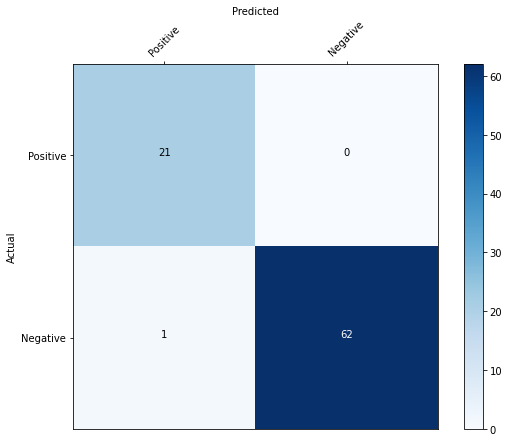

In [58]:
#@title Pierre - Confusion Matrix { vertical-output: true, display-mode: "form" }
def plot_confusion_matrix(cm,
                          title_names,
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    if title_names is not None:
        tick_marks = np.arange(len(title_names))
        plt.xticks(tick_marks, title_names, rotation=45)
        plt.yticks(tick_marks, title_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.show()



plot_confusion_matrix(cm           = pierre_confusion_matrix, 
                      normalize    = False,
                      title_names = ['Positive','Negative'])

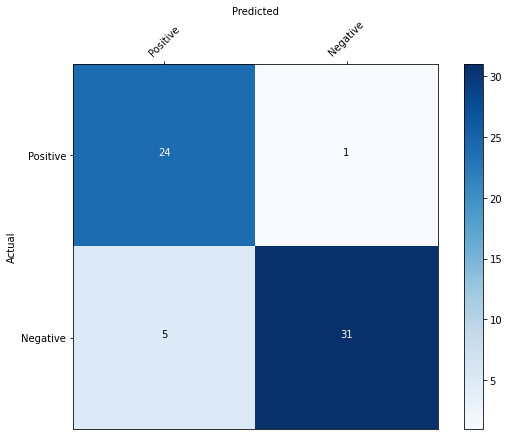

In [59]:
#@title Marie - Confusion Matrix { vertical-output: true, display-mode: "form" }
plot_confusion_matrix(cm           = marie_confusion_matrix, 
                      normalize    = False,
                      title_names = ['Positive','Negative'])

## Precision, Recall & F1 🏹

---
Further metrics can be calculated from our confusion matrices.

> $Precision = \frac{TP}{TP + FP}$

> $Recall=\frac{TP}{TP+FN}$

> $F1=2\: \frac{precision\: *\: recall}{precision+recall}$

In [60]:
class Metrics:
  def __init__(self, p=None, r=None, f=None):
    self.precision = p
    self.recall = r
    self.f1 = f

  def matrix_scores(self, m, inline=True):
    #[[TP, FP],
    #[FN, TN]]
    self.precision = m[0,0] / (m[0,0] + m[0,1])
    self.recall = m[0,0] / (m[0,0] + m[1,0])
    self.f1 = 2 * ((self.precision * self.recall) / (self.precision + self.recall))
    if inline: return self
  
  def __str__(self):
    return f"Precision: {self.precision}\nRecall: {self.recall}\nF1 Score: {self.f1}\n"


pierre_metrics = Metrics().matrix_scores(pierre_confusion_matrix)
marie_metrics = Metrics().matrix_scores(marie_confusion_matrix)

print(f"____Pierre____\n{pierre_metrics}")
print(f"____Marie____\n{marie_metrics}")

macro_metrics = Metrics(p = np.mean([pierre_metrics.precision, marie_metrics.precision]),
                        r = np.mean([pierre_metrics.recall, marie_metrics.recall]),
                        f = np.mean([pierre_metrics.f1, marie_metrics.f1]))

print(f"____Average over Documents (Macro Scores)____\n{macro_metrics}")

____Pierre____
Precision: 1.0
Recall: 0.9545454545454546
F1 Score: 0.9767441860465117

____Marie____
Precision: 0.96
Recall: 0.8275862068965517
F1 Score: 0.888888888888889

____Average over Documents (Macro Scores)____
Precision: 0.98
Recall: 0.8910658307210031
F1 Score: 0.9328165374677003



## Discussion 🗣

---

Excellent, now we have a numerical reference with which to discuss the performance of the model. Our pipeline shows:

* Generally strong performance, with particularly high precision.

* Appears fairly robust, suffering only a small performance hit when operating upon the unseen dataset.

* If we had to pick a worst-score, our pipeline's recall could use work.

The low recall is due to the number of False Negatives in our experiment. These were due to the lack of handling of shortened date ranges (e.g. 1905-06). Arguably, the recall is even worse if we were to evaluate decades more thoroughly.

Interestingly, the only False Positive occured due to the NLTK sentence tokenizer. By incorrectly failing to seperate the strings based on our sentence definition, an extra sentence was included despite not containing a date.


# Timeline ✨🎉🎈

---

Woohoo! The last thing left to do is to find overlapping dates between Marie and Pierre's biographies. Then we can show them in a pretty Gantt chart!

In [93]:
#Inner join on ISO Date index
joint_events = pd.merge(pierre_automatic_results,marie_automatic_results, how='inner', left_index=True, right_index=True).drop(columns=["Date_x","Date_y"])
joint_events["Sentence"] = "Pierre: " + joint_events.Sentence_x + "\n" + "Marie:" + joint_events.Sentence_y
joint_events.drop(columns=["Sentence_x", "Sentence_y"], inplace=True)
joint_events

,Sentence
ISO,
1890-01-01,"Pierre: Even now, all their papers from the 18..."
1895-07-26,"Pierre: She refused his initial proposal, but ..."
1898-01-01,Pierre: Pierre Curie's 1898 publication with h...
1898-01-01,Pierre: Pierre Curie's 1898 publication with h...
1905-01-01,Pierre: He did not attend séances such as thos...
1906-04-19,"Pierre: Pierre Curie (/ˈkjʊəri/, KEWR-ee; Fren..."
1906-04-19,Pierre: Pierre Curie died in a street accident...
1934-01-01,Pierre: They experienced radiation sickness an...
1934-01-01,Pierre: They experienced radiation sickness an...


In [ ]:
#Collect all the results into a single dataframe,
#padding out dates until the next event to look nice for the timeline
def result_to_graph_df(res, label):
  out = res.copy()
  out.sort_index(inplace=True)
  out["Start"] = out.index
  out["Finish"] = pd.NaT
  out["Finish"].iloc[:-1] = out.index[1:]
  out["Finish"].iloc[-1] = out.index[-1] + timedelta(days=365)
  out["Task"] = label
  return out

pierre_df = result_to_graph_df(pierre_automatic_results, "Pierre")
marie_df = result_to_graph_df(marie_automatic_results, "Marie")
joint_df = result_to_graph_df(joint_events, "Joint Events")

stacked_df = pd.concat([pierre_df, joint_df, marie_df], axis=0)

In [102]:
fig = px.timeline(stacked_df[["Start","Task","Finish","Sentence"]], 
                  x_start="Start", 
                  x_end="Finish", 
                  y="Task", 
                  color="Sentence",
                  color_discrete_sequence=px.colors.diverging.Spectral
                  )
fig.update_yaxes(autorange="reversed")
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(dict(showlegend=False, ))

fig.update_layout(go.Layout(
    title=dict(x=0.45),
    yaxis=dict(title=''),
    xaxis=dict(title='Date'),
    title_text=f"Timeline - Pierre & Marie Curie ☢",
    template="plotly_dark"))